### Import Packages


In [2]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Make a model.py, and define your model (class) inside the model. 
from model_ResNext101328d import Model

print(torch.__version__)

1.10.0+cu111


### Import your drive's contents!

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's define our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the path to "data_path"

In [7]:
test_path = '/content/drive/MyDrive/TUM/pokemon/test'
model_dir = '/content/drive/MyDrive/TUM/assignments i2dl/'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [8]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)

        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Create dataset/dataloader for test 

In [9]:
test_dataset = PokemonDataset(test_path, classes)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Try to sample out one test dataset

In [10]:
sample = next(iter(test_dataloader))

Text(0.5, 1.0, 'bug')

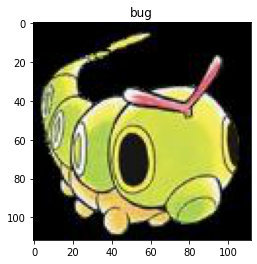

In [11]:
plot_idx = 0
plt.imshow(sample['original_img'][plot_idx].permute(1, 2, 0))
plt.title(sample['class_name'][plot_idx])

### Choose your device - use GPU or not?

In [12]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Load the Saved CheckPoint

In [13]:
# Code referred from: https://discuss.pytorch.org/t/saving-customized-model-architecture/21512/2
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    return model

In [14]:
model_path = '/content/drive/MyDrive/TUM/0.88augmented_pokemon_resn101_best.pth' 
model = load_checkpoint(model_path)

### Define a function for test

In [15]:
def test(model, sample):
    model.eval()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return num_correct.item()

### Run Test

In [16]:
### Validation Phase
# Initialize Loss and Accuracy
test_accu = 0.0

# Iterate over the val_dataloader
with tqdm(total=len(test_dataloader)) as pbar:
    for idx, sample in enumerate(test_dataloader):
        num_correct = test(model, sample)
        test_accu += num_correct / len(test_dataloader)
        pbar.update(1)

print('Total Accuracy: ', test_accu)

  0%|          | 0/60 [00:00<?, ?it/s]

Total Accuracy:  0.8833333333333344
